# Dados COVID19 em .ipynb  30/04/2020

        Estou tentando importar e utilizar os dados do Ministério da Saúde em
    https://covid.saude.org.br para avaliar a situação divulgada oficialmente
    pelo MS; A url muda diariamente, há uma série de caracteres em primeira
    vista aleatórios que é atualizada também todo dia... como puxar o arquivo
    csv automaticamente?
    
        O site não disponibiliza dados de SRAG, apenas uma tabela repetida e
        desatualizada do COVID19. 
    
        Nova tabela com dados do Brasil (população)
    
        Dados de SRAG da fiocruz estão no padrão brasileiro (109,0009) como
    transformar o arquivo em padrão americano/internacional (109.0009)
    automaticamente pela URL?

## Gráficos dos Dados

        Mostrar infectados e mortes confirmados diariamente
        Mostrar infectados e mortes confirmados acumulados
        Mostrar dados separados por região e por estado
        
            Mostrar dados de SRAG e comparar com o aumento dos números
            confirmados de COVID
        Dados em semana epidemiológica

## Estimativas (Regressão)
        
            Estimar próximos números (até 7 dias?) utilizando 3 dias anteriores
        e regressão não linear
        
            Estimar curvas com ajuda dos dados de SRAG inconclusivos (qual a 
        porcentagem de testes incompletos espera-se que serão confirmados)
        
## Modelo de Contágio

            Utilizar dados adquiridos para rodar um modelo epidemiológico que
        utiliza valores de reprodução base e evolução da COVID-19, causada
        pelo vírus SARS-COV-2
  

## Creating the base of the code

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Databases

url_B = "https://raw.githubusercontent.com/Yannngn/COVID19-04-20/master/brasil.csv"
url_C = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/1d2b944e065c7304b2754cc386635e38_Download_COVID19_20200430.csv"

In [2]:
brasil = pd.read_csv(url_B, sep = ';')
df = pd.read_csv(url_C, sep = ";")

In [3]:
FMT = '%Y-%m-%d'

date = df['data']
regi = df['regiao']

df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)

In [4]:
df_BR = brasil.loc[range(27), ['UF', 'Unidade da Federação', 'Regiao', 'População']]
df_BR = df_BR.sort_values('UF')

df = df.sort_values('estado')

df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
dfs = df.loc[:, ['regiao', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos', 'estado']]
df_UF = df.loc[:, ['estado', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

In [5]:
df1 = df1.groupby("data").sum()

# total of days since 2020-01-30 - x
days = list(df1.index)
x = days

## Exponential Model

In [6]:
# exponential model for the evolution of the covid 19 in Brazil

def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

def exp_param (R, X) :
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return [a, b]

def exp_est (R, X) :
    np.random.seed(max(x))
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return a * np.exp(b * (max(x) + 1)) + norm.rvs(size = 1,scale = 0.05 * (max(x) + 1))

## Logistic Model

In [7]:
# logistic model for the evolution of the covid 19 in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

a0 = 2.7

lb = [df1.index.size + 31, df1.index.size + 86, df1.index.size + 45, df1.index.size + 45]

pBrasil = brasil.at[brasil['UF'].eq('BR').idxmax(),'População']
lc = [0.2 * pBrasil, 0.001 * pBrasil, 0.008 * pBrasil, 0.00016 * pBrasil]

## Data for every Brazilian State

### Population
    Source: IBGE
    
### Last Confimed Numbers
    Source: covid.saude.gov.br
    
### Incidence of Cases and Deaths
    Number of cases or deaths for million citizens
    
### Speed of the Contamination
    How many days does the COVID takes to double in every state

In [8]:
casosInc = []
casosDia = []
casosCres = []
obitosInc = []
obitosDia = []
obitosCres = []
dfs = dfs.sort_values('estado')
estados = dfs["estado"].unique()
x = days

for e in estados :
    pop = brasil.at[brasil['UF'].eq(e).idxmax(),'População']
    uf = brasil.at[brasil['UF'].eq(e).idxmax(), "Unidade da Federação"]
    
    # Values for daily cases
    df_e = df_UF.loc[df_UF.iloc[:,0] == e, :].iloc[:, [1, 2]].sort_values("data")
    y = list(df_e.iloc[:, 1])
    casosDia.append(round(y[max(days)], 2))
    casosInc.append(round((10 ** 6) * y[max(days)] / pop, 2))
    
    exp_p = exp_param([y[-5], y[-3], y[-1]], [x[-5], x[-3], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] * np.exp(-1), exp_p[1], 1])
    casosCres.append(round(np.log(2) / exponential_fit[0][1], 1))
    
    # Values for daily deaths
    df_e = df_UF.loc[df_UF.iloc[:,0] == e, :].iloc[:, [1, 4]].sort_values("data")
    y = list(df_e.iloc[:, 1])
    obitosInc.append(round((10 ** 6) * y[max(days)] / pop, 2))
    obitosDia.append(round(y[max(days)], 2))
    
    exp_p = exp_param([y[-5], y[-3], y[-1]], [x[-5], x[-3], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] * np.exp(-1), exp_p[1], 1])
    obitosCres.append(round(np.log(2) / exponential_fit[0][1], 1))
    
df_BR['Casos'] = casosDia
df_BR['Incidência de Casos'] = casosInc
df_BR['Dias para dobrar (casos)'] = casosCres
df_BR['Mortes'] = obitosDia
df_BR['Incidência de Mortes'] = obitosInc
df_BR['Dias para dobrar (obitos)'] = obitosCres
df_BR = df_BR.sort_values('Incidência de Casos', ascending = False)
df_BR.reset_index(drop = True, inplace = True)

df_BR

C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


,UF,Unidade da Federação,Regiao,População,Casos,Incidência de Casos,Dias para dobrar (casos),Mortes,Incidência de Mortes,Dias para dobrar (obitos)
0,AP,Amapá,Norte,842914,1080,1281.27,7.0,34,40.34,6.1
1,AM,Amazonas,Norte,4240210,5254,1239.09,7.7,425,100.23,6.9
2,RR,Roraima,Norte,546891,519,949.00,7.2,7,12.80,9.4
3,CE,Ceará,Nordeste,9178363,7606,828.69,7.9,482,52.51,6.9
4,PE,Pernambuco,Nordeste,9650604,6876,712.49,6.5,565,58.55,6.7
5,SP,São Paulo,Sudeste,46064928,28698,622.99,9.6,2375,51.56,8.3
6,ES,Espírito Santo,Sudeste,4138657,2465,595.60,7.4,83,20.05,6.5
7,RJ,Rio de Janeiro,Sudeste,16946541,9453,557.81,9.3,854,50.39,7.8
8,AC,Acre,Norte,866811,404,466.08,8.2,19,21.92,6.2
9,MA,Maranhão,Nordeste,7121156,3190,447.96,6.5,184,25.84,5.6



## Plots

### Daily Confirmed Number by Brazilian regions 
    
    Norte
    Centro-Oeste
    Nordeste
    Sudeste
    Sul
    
    New Confirmed Cases
    New Confimed Deaths    

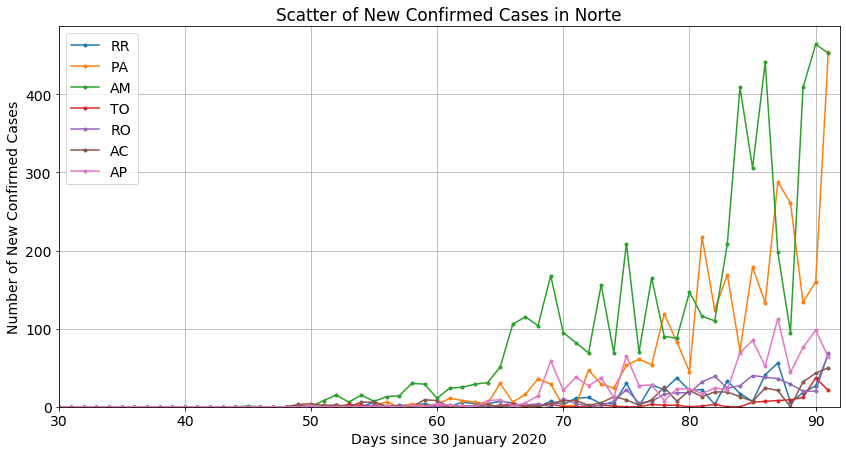

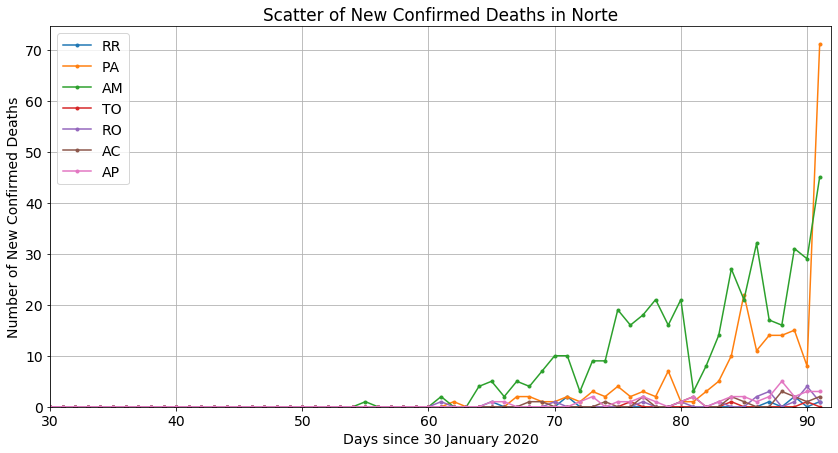

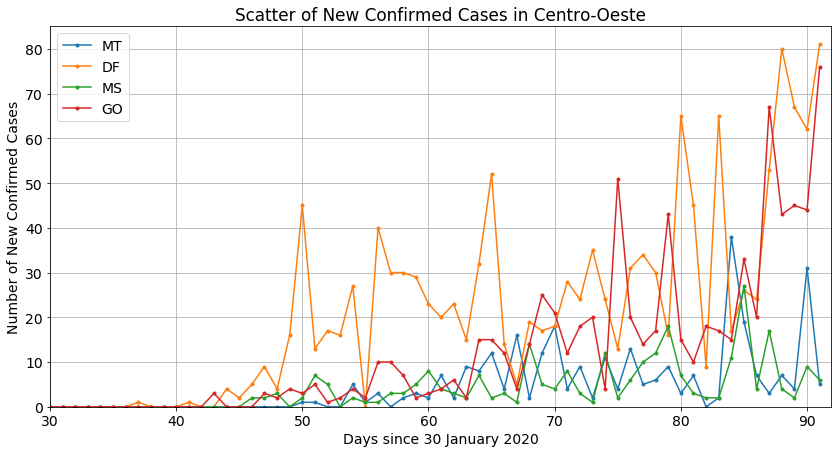

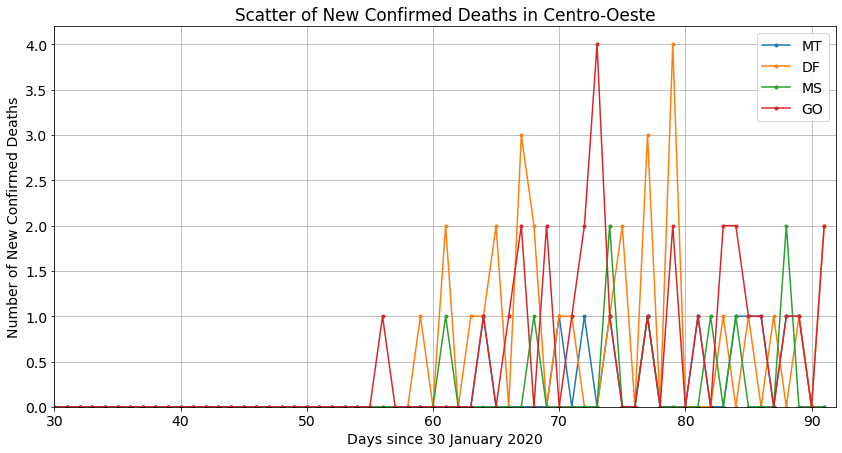

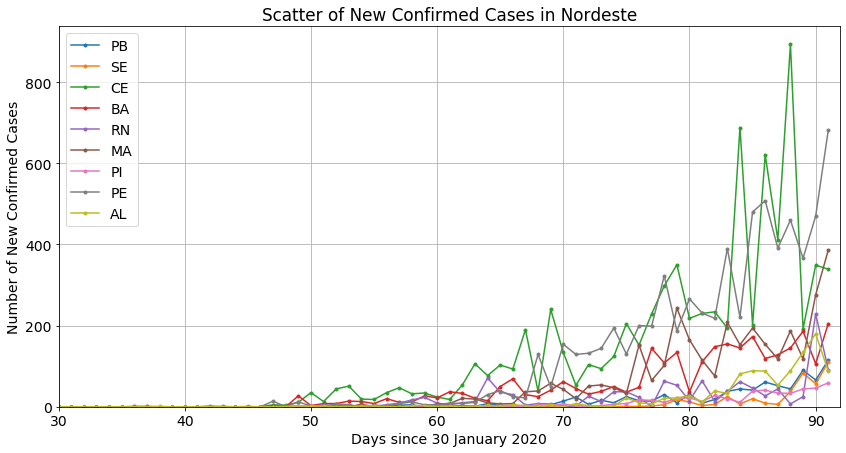

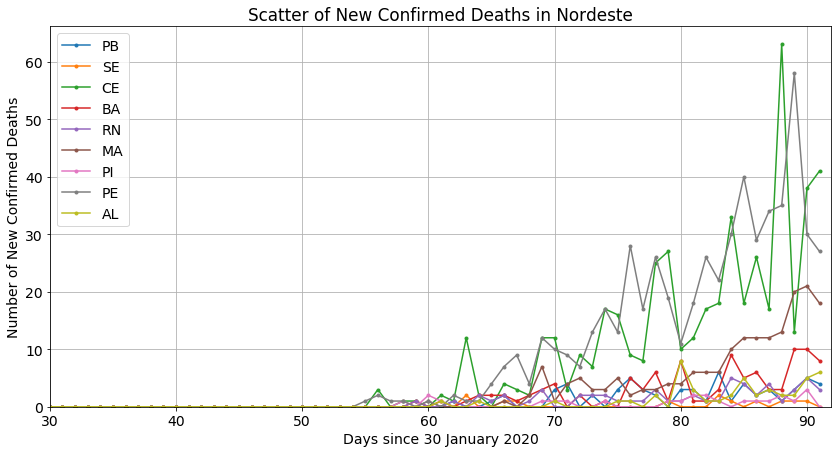

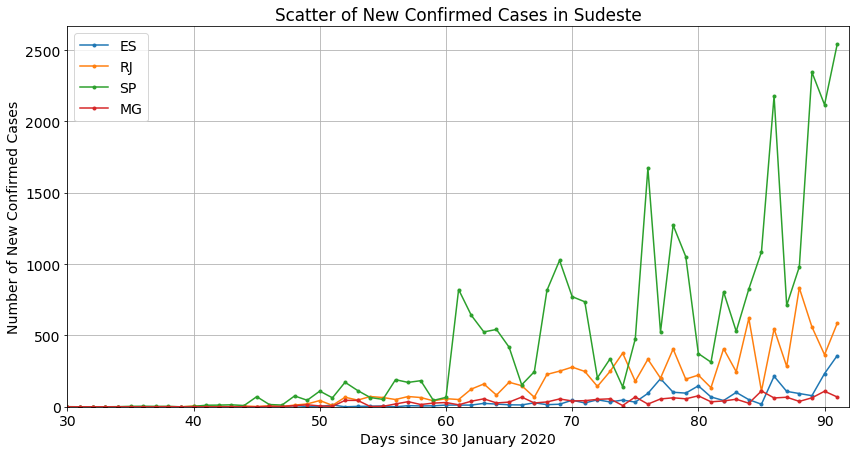

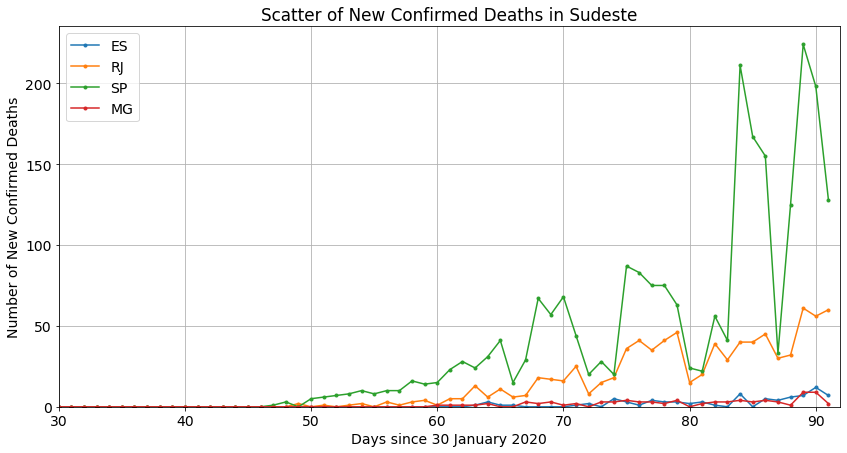

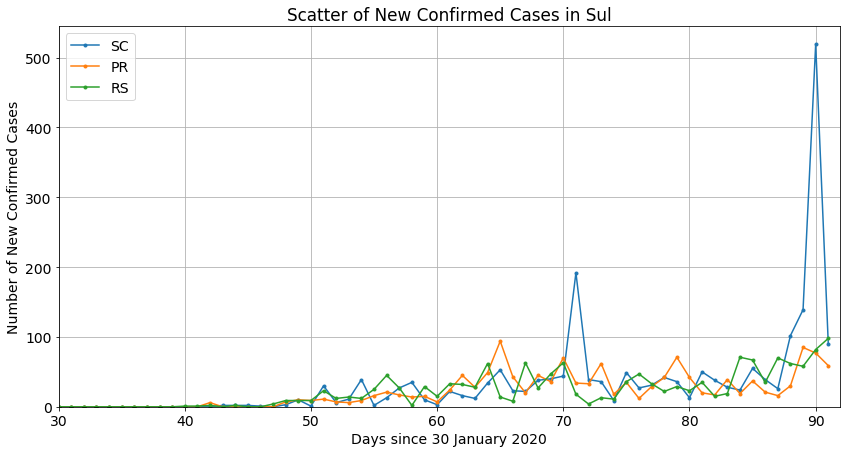

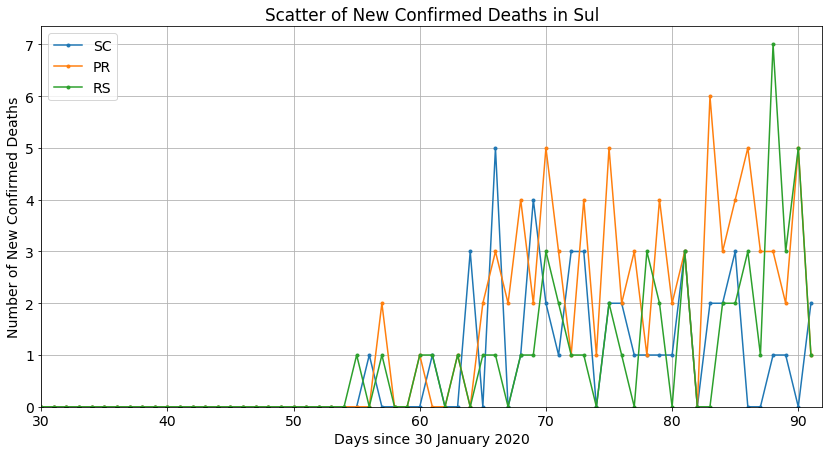

In [9]:
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

ttl = ["New Confirmed Cases", "New Confirmed Deaths"]
dfs = dfs.sort_values("data")
regioes = dfs["regiao"].unique()
estados = list(dfs["estado"].unique())

# Real data
# Brazilian areas separated
for r in regioes :    
    for f in range(2) : 
        for e in estados :
            plt.grid(True)
            
            uf = brasil.at[brasil['UF'].eq(e).idxmax(), "Regiao"]
            yx = max(dfs[dfs['regiao'] == r].iloc[:, 3 + (2 * f)])
            
            if uf == r :
                xs = days
                ys = list(dfs[dfs['estado'] == e].iloc[:, 3 + (2 * f)])
                plt.plot(xs, ys, marker = '.', label = e)
        plt.title("Scatter of " + ttl[f] + " in " + r)
        plt.legend()
        plt.xlabel("Days since 30 January 2020")
        plt.ylabel("Number of " + ttl[f])
        plt.xlim(30, max(xs) * 1.01)
        plt.ylim(0, yx * 1.05)
        plt.show()

## Casos Totais por estado
    
    Casos confirmados x tempo
    
    Dados reais, estimativa exponencial e em estados com mais de 1000 casos estimativa logistica
    
    Os dados são subnotificados e possuem baixa confiabilidade

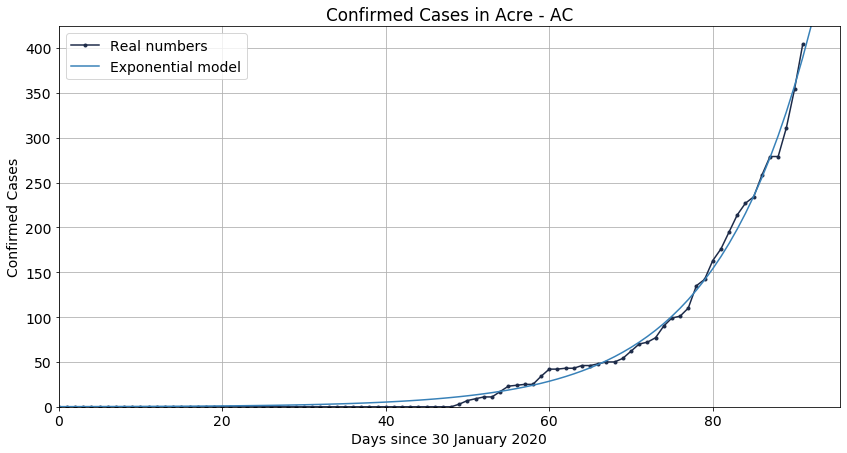

Next estimated number of confirmed cases is 423.412 or +19.412


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


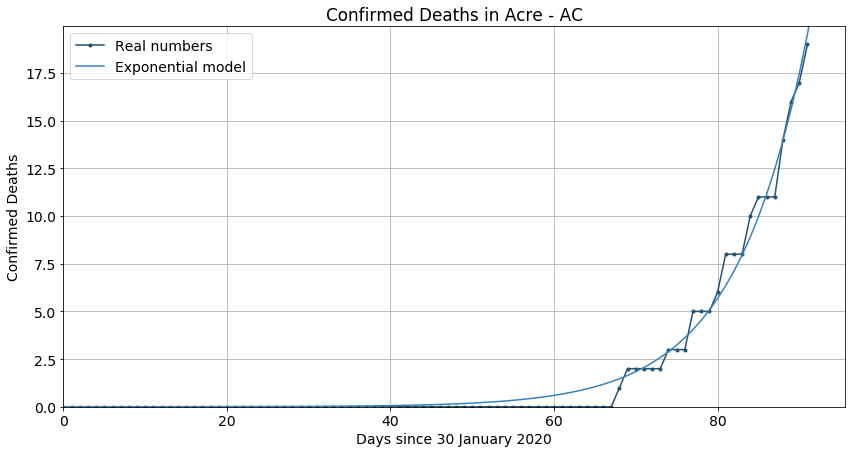

Next estimated number of confirmed cases is 21.868 or +2.868


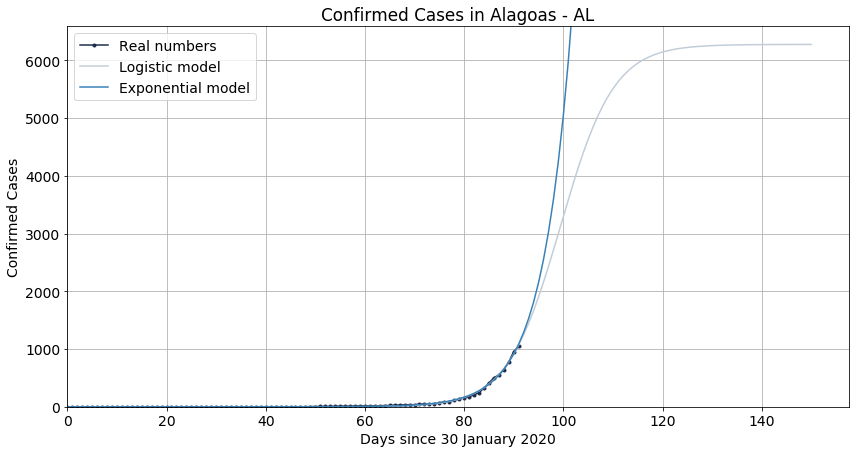

Next estimated number of confirmed cases is 1287.105 or +243.105


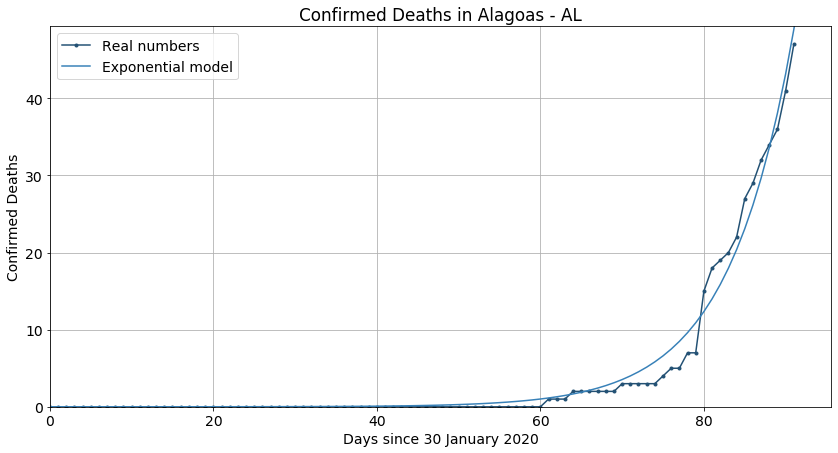

Next estimated number of confirmed cases is 55.467 or +8.467


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


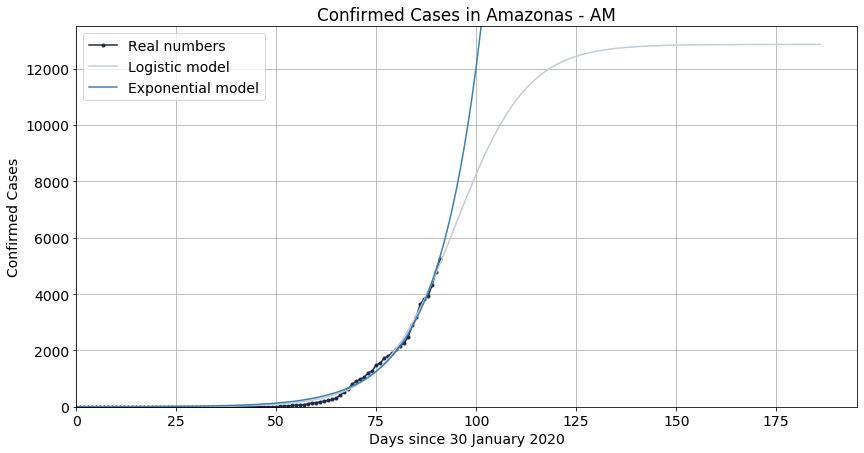

Next estimated number of confirmed cases is 5855.522 or +601.522


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


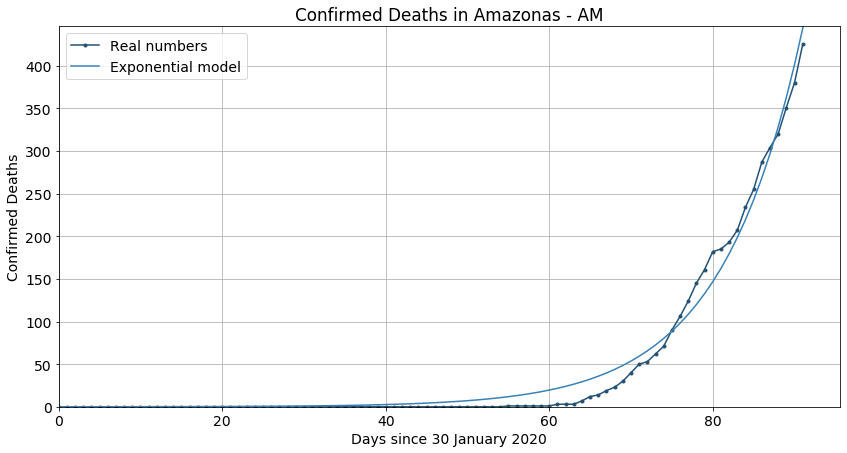

Next estimated number of confirmed cases is 490.704 or +65.704


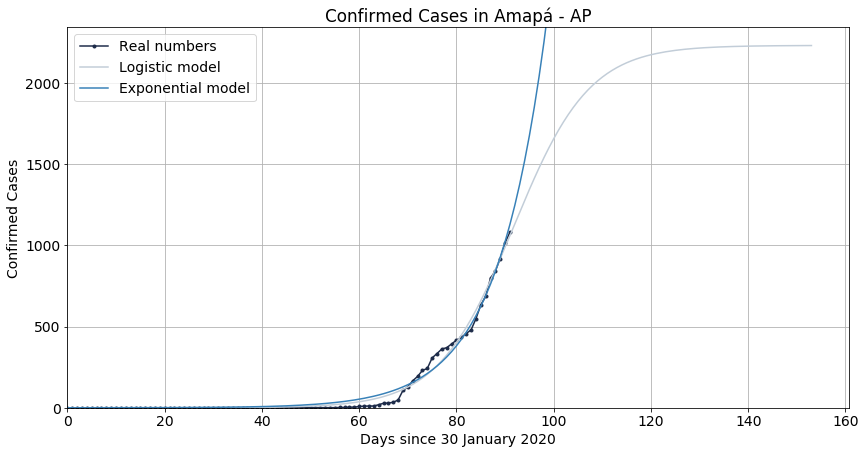

Next estimated number of confirmed cases is 1245.971 or +165.971


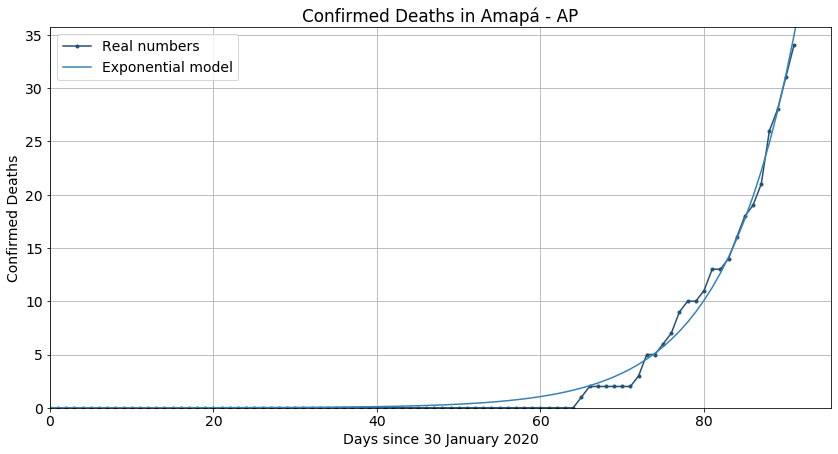

Next estimated number of confirmed cases is 39.076 or +5.076


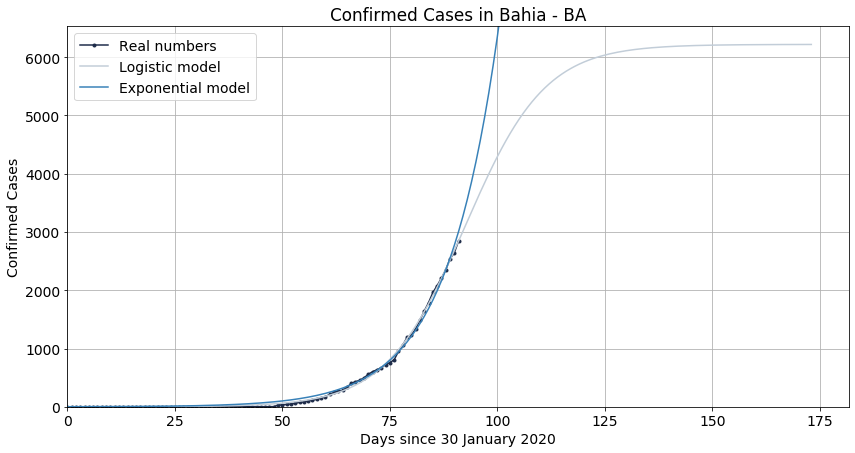

Next estimated number of confirmed cases is 3274.571 or +423.571


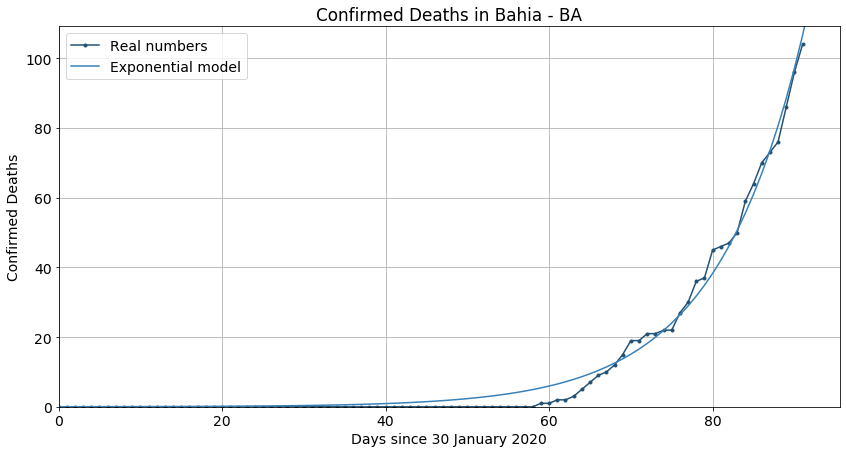

Next estimated number of confirmed cases is 116.981 or +12.981


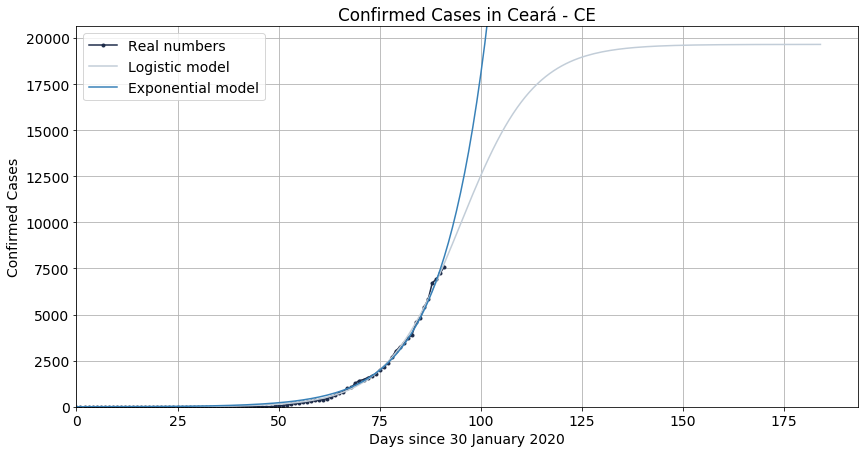

Next estimated number of confirmed cases is 8913.326 or +1307.326


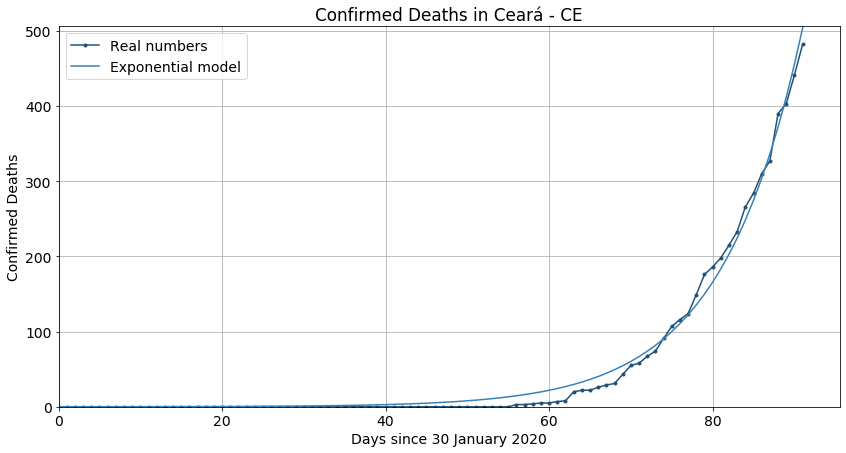

Next estimated number of confirmed cases is 557.208 or +75.208


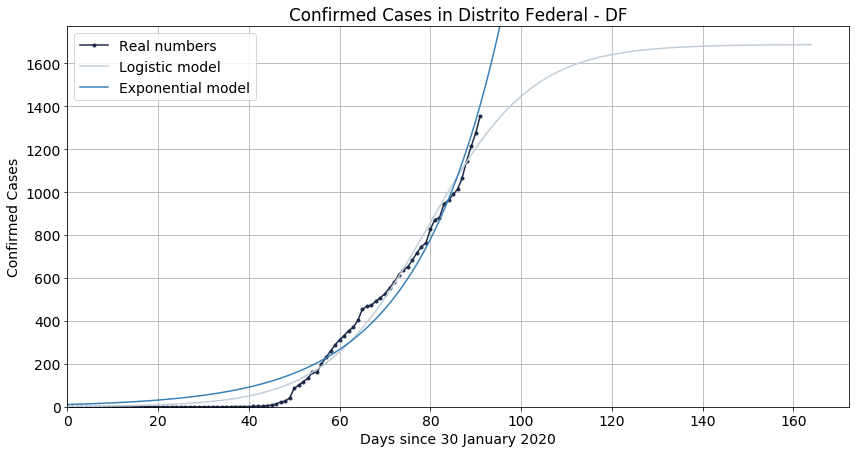

Next estimated number of confirmed cases is 1484.329 or +128.329


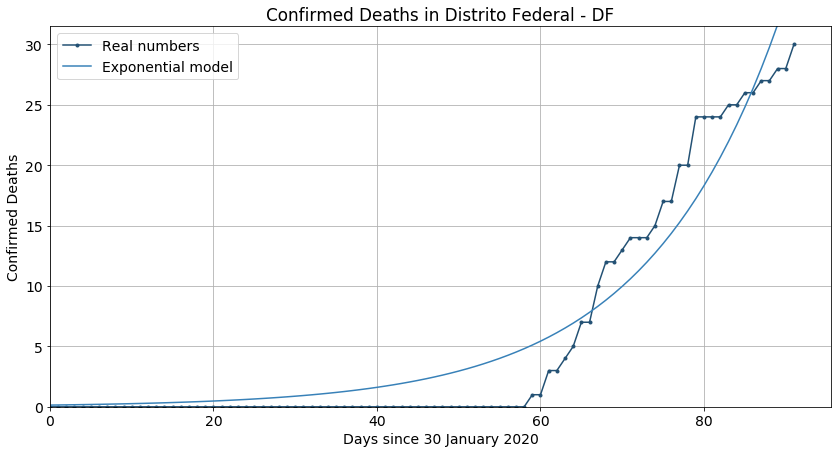

Next estimated number of confirmed cases is 37.952 or +7.952


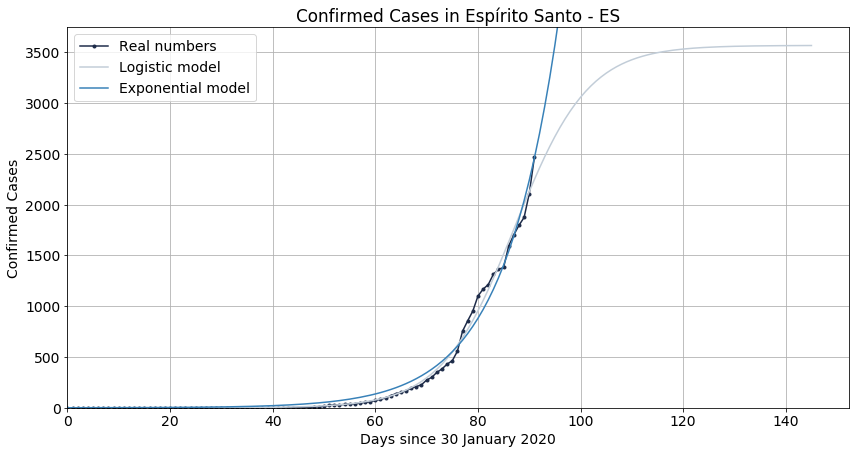

Next estimated number of confirmed cases is 2698.314 or +233.314


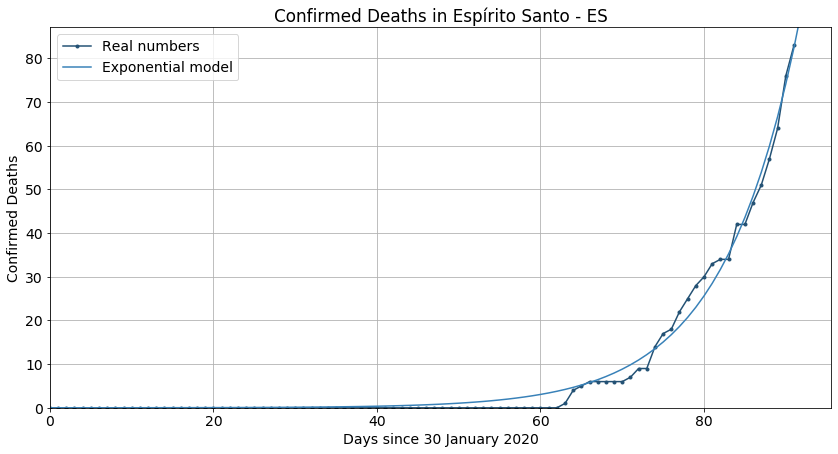

Next estimated number of confirmed cases is 91.707 or +8.707


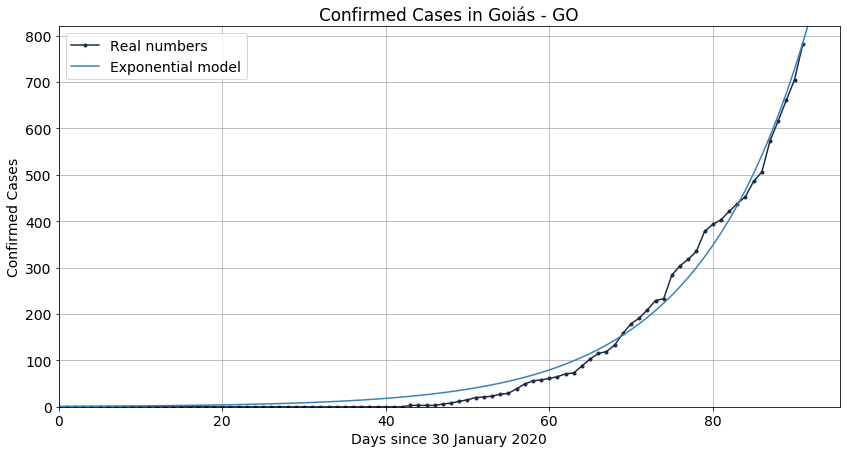

Next estimated number of confirmed cases is 843.598 or +62.598


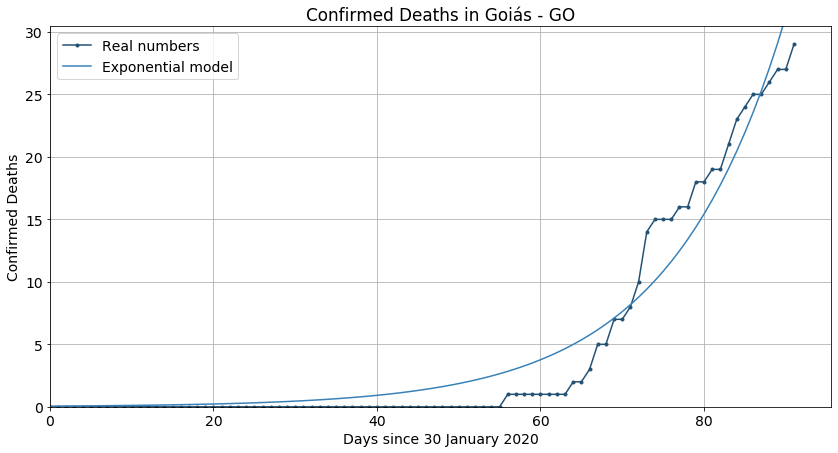

Next estimated number of confirmed cases is 35.953 or +6.953


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


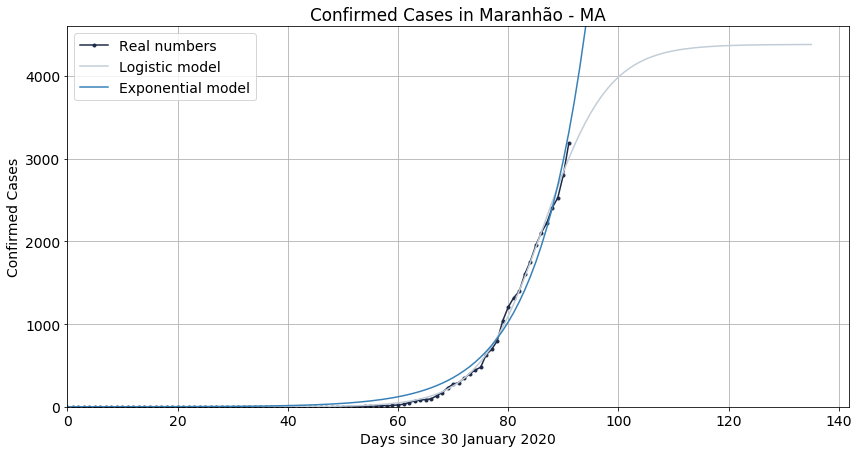

Next estimated number of confirmed cases is 3693.448 or +503.448


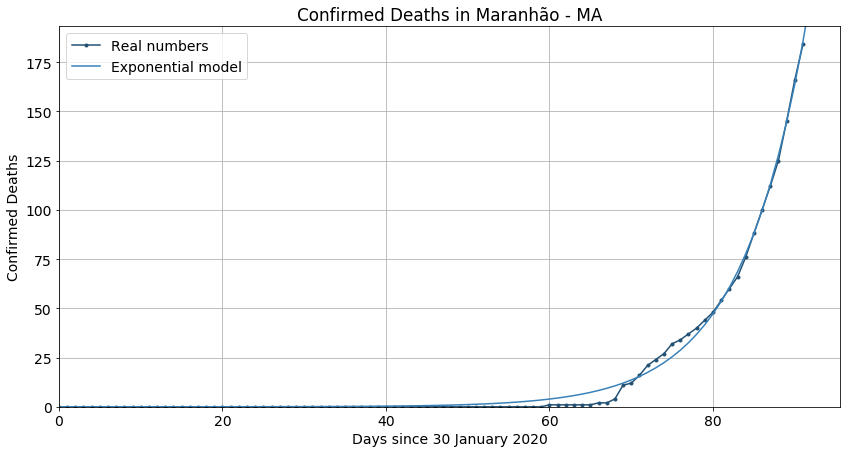

Next estimated number of confirmed cases is 209.941 or +25.941


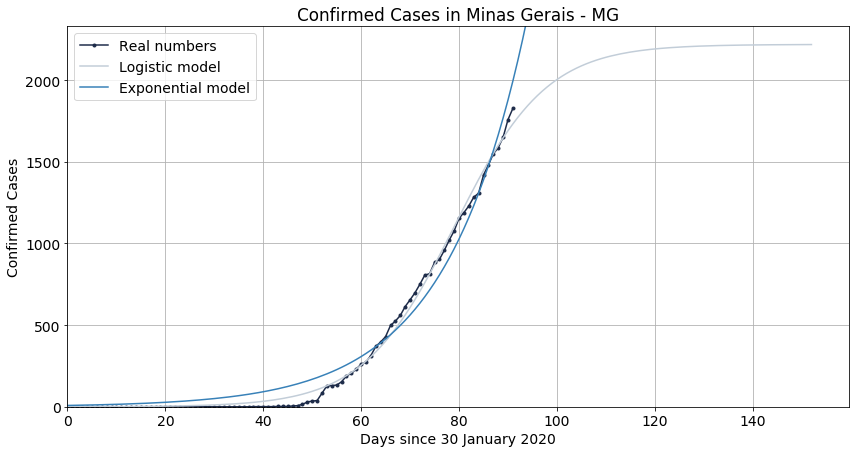

Next estimated number of confirmed cases is 2118.478 or +291.478


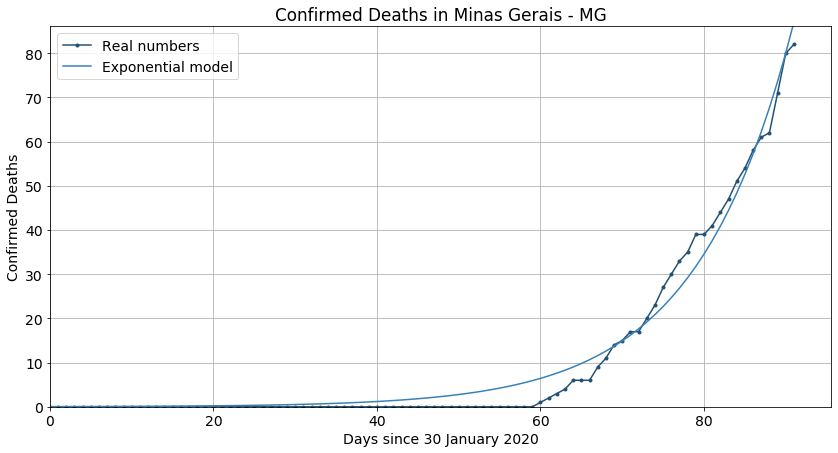

Next estimated number of confirmed cases is 94.714 or +12.714


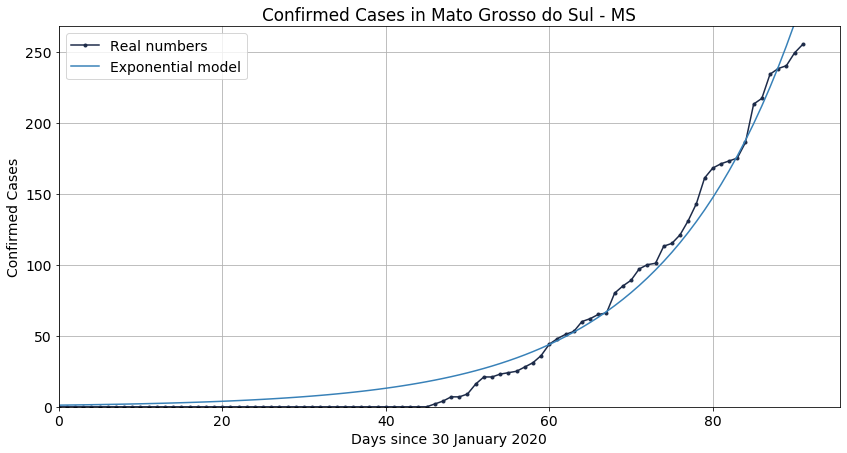

Next estimated number of confirmed cases is 304.439 or +49.439


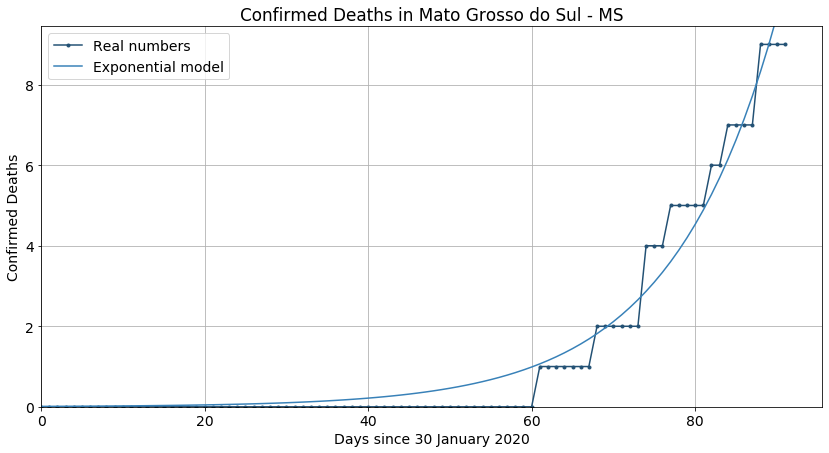

Next estimated number of confirmed cases is 11.294 or +2.294


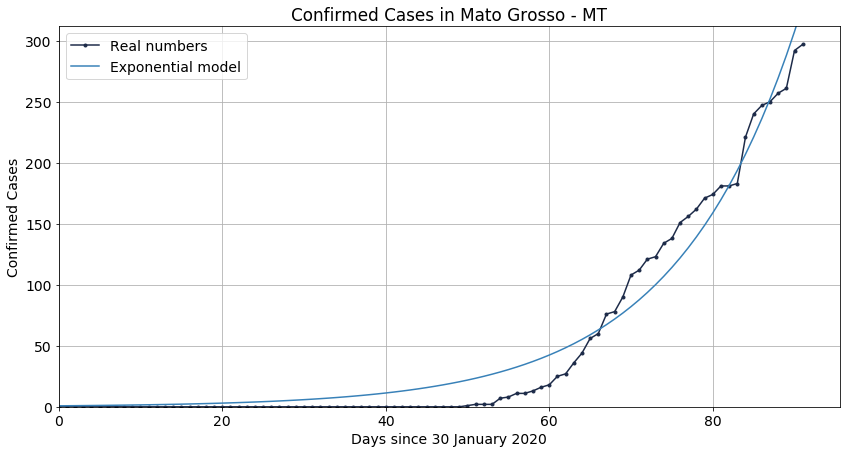

Next estimated number of confirmed cases is 351.039 or +54.039


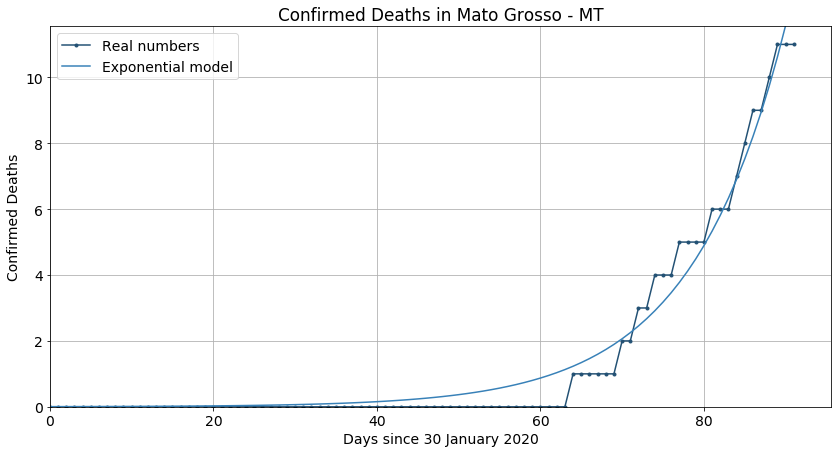

Next estimated number of confirmed cases is 13.759 or +2.759


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


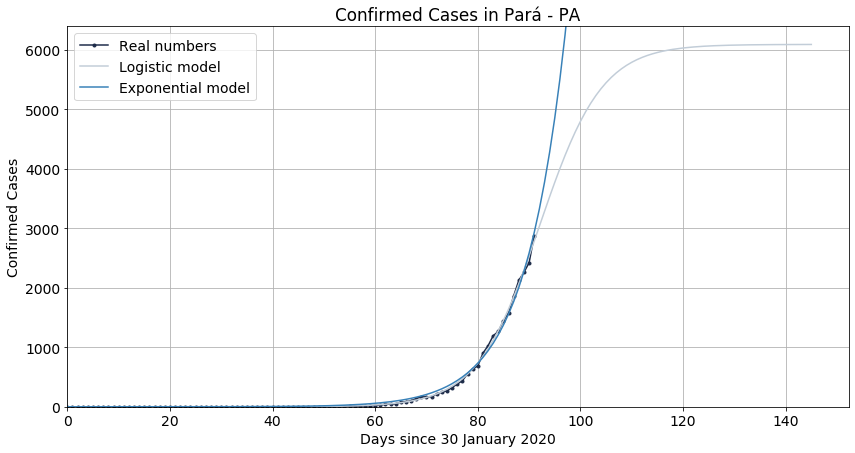

Next estimated number of confirmed cases is 3326.416 or +450.416


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


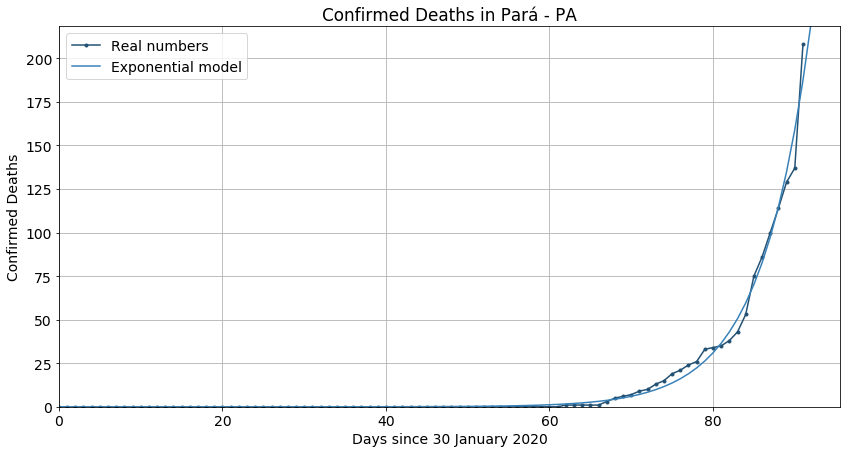

Next estimated number of confirmed cases is 220.56 or +12.56


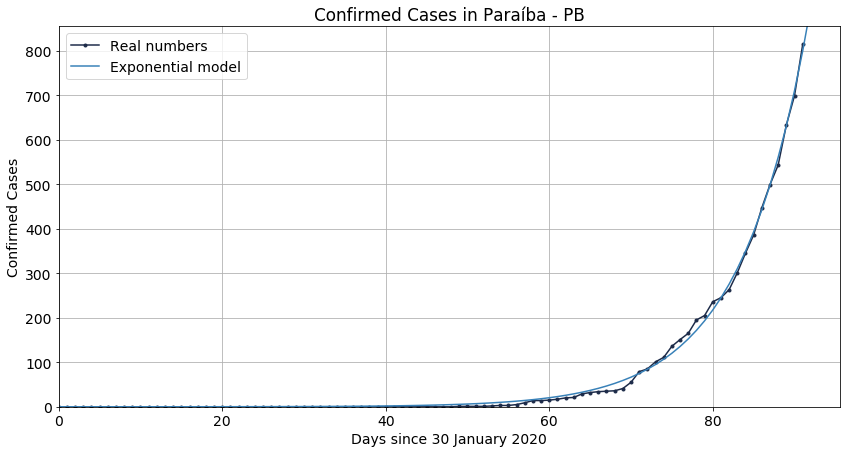

Next estimated number of confirmed cases is 899.782 or +85.782


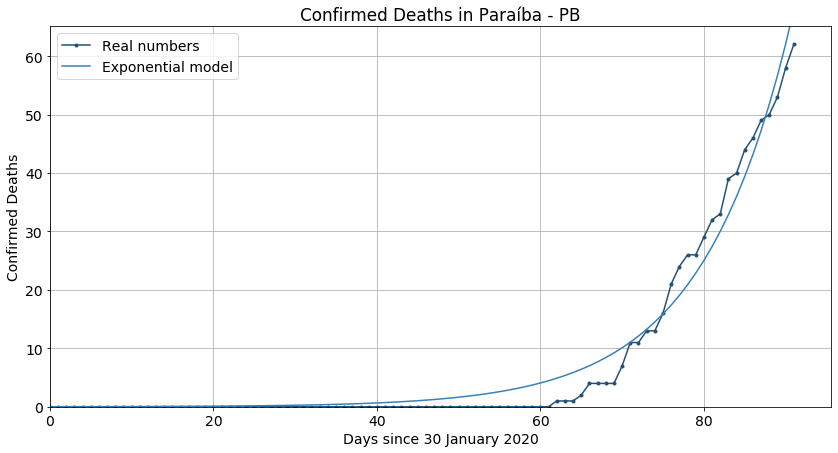

Next estimated number of confirmed cases is 74.425 or +12.425


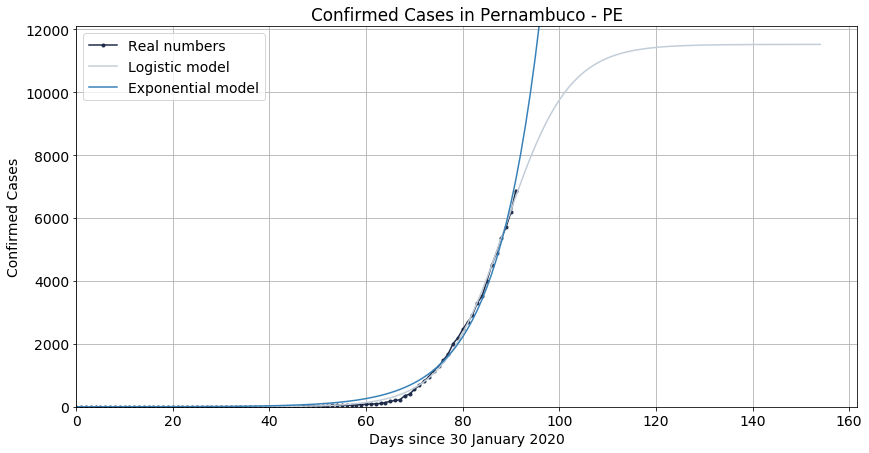

Next estimated number of confirmed cases is 8039.848 or +1163.848


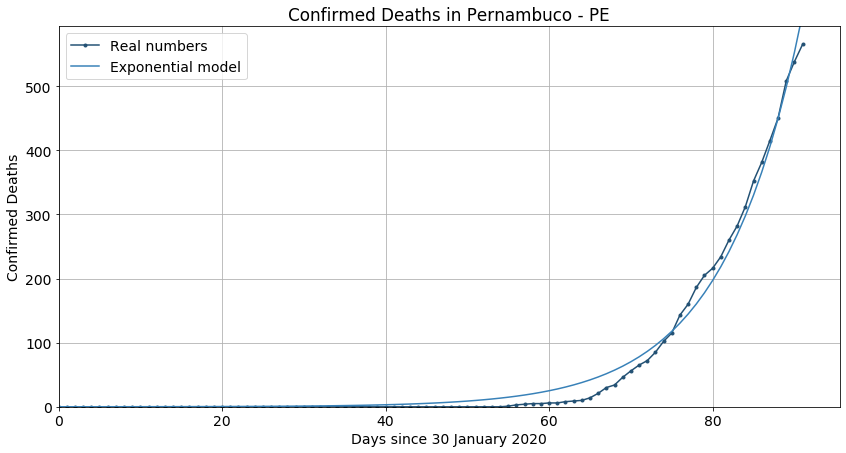

Next estimated number of confirmed cases is 678.992 or +113.992


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


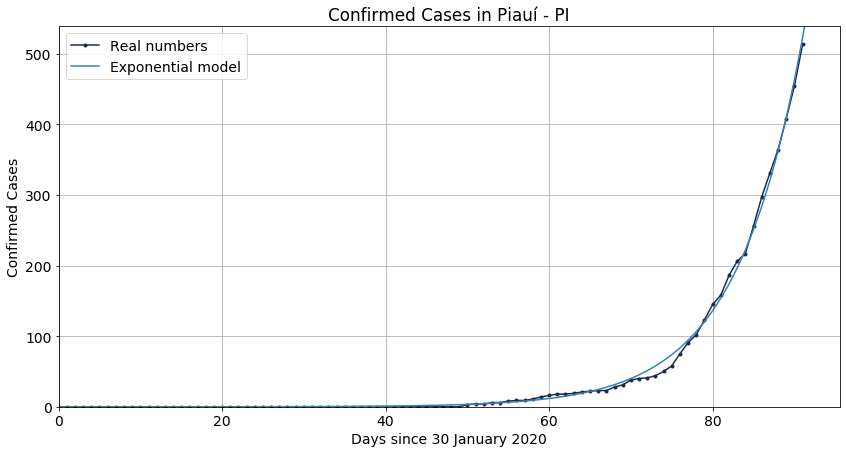

Next estimated number of confirmed cases is 590.351 or +77.351


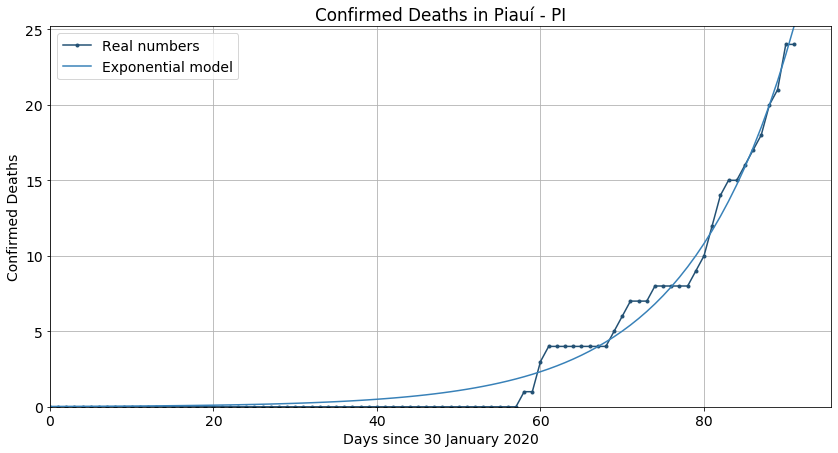

Next estimated number of confirmed cases is 27.192 or +3.192


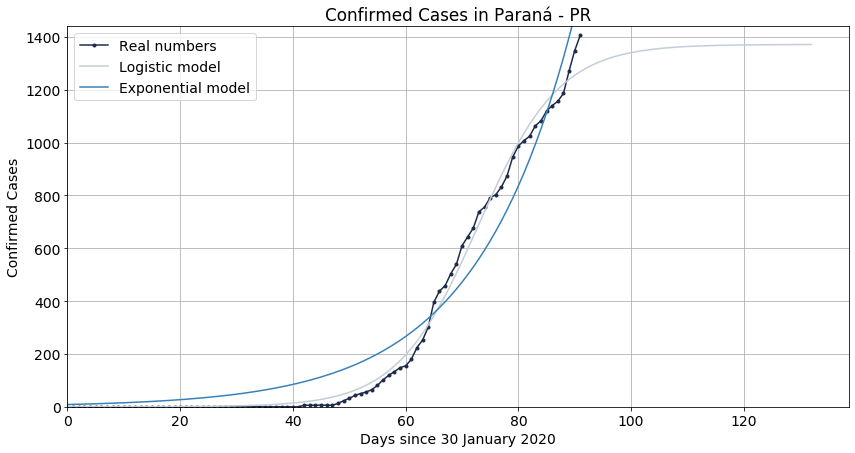

Next estimated number of confirmed cases is 1660.857 or +253.857


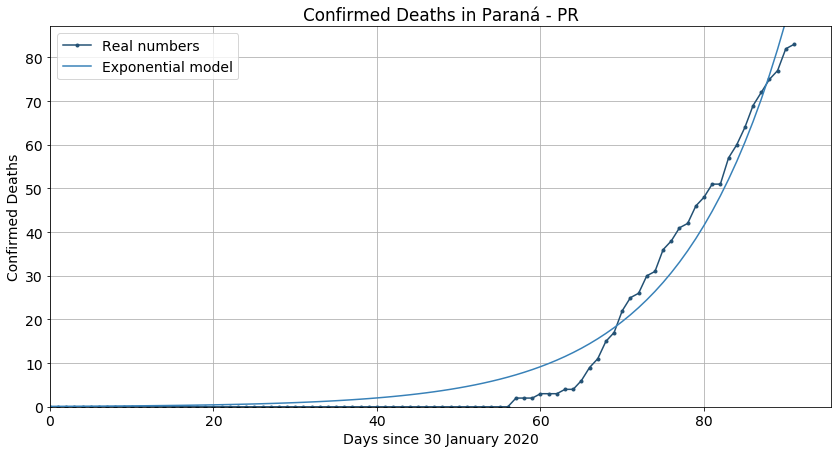

Next estimated number of confirmed cases is 102.717 or +19.717


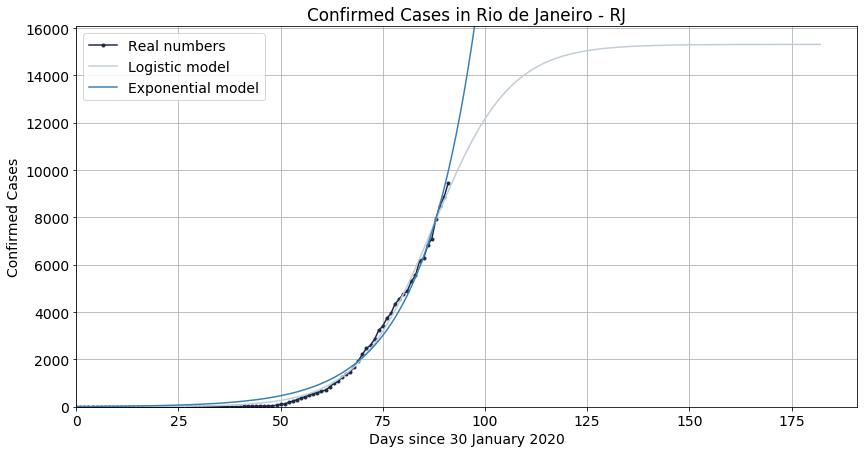

Next estimated number of confirmed cases is 10714.042 or +1261.042


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


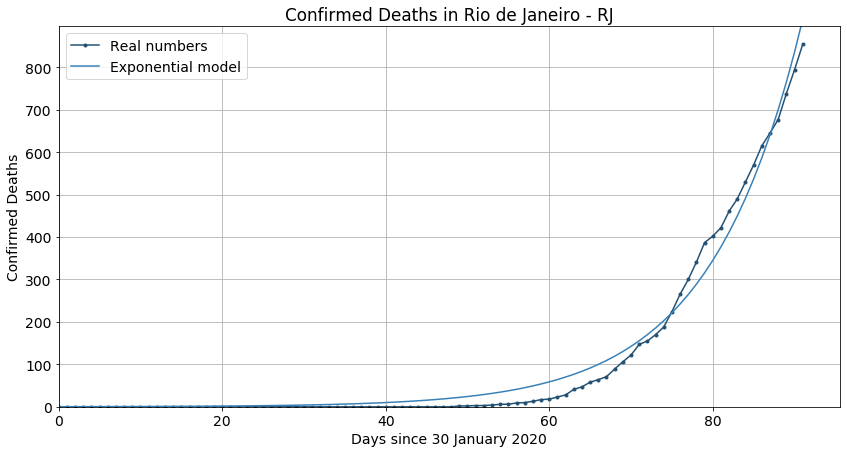

Next estimated number of confirmed cases is 997.514 or +143.514


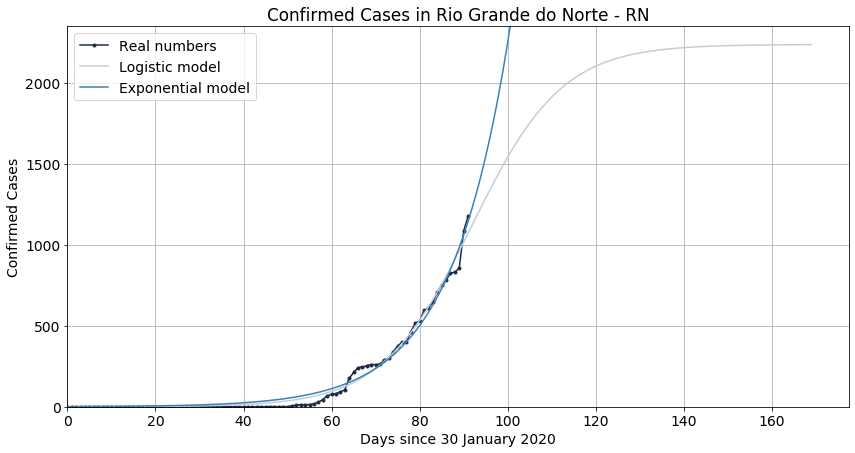

Next estimated number of confirmed cases is 1234.132 or +57.132


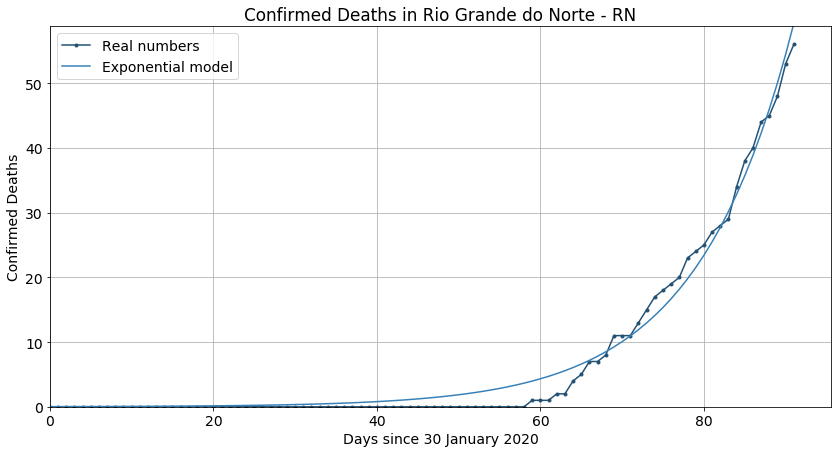

Next estimated number of confirmed cases is 64.477 or +8.477


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


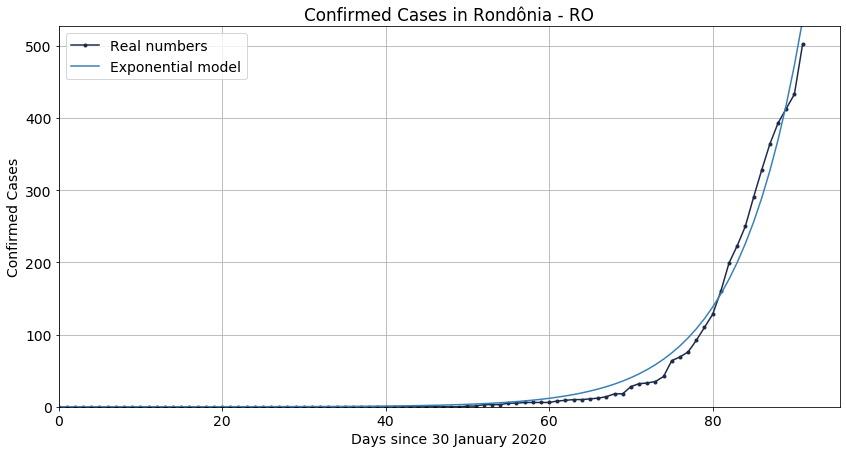

Next estimated number of confirmed cases is 605.252 or +103.252


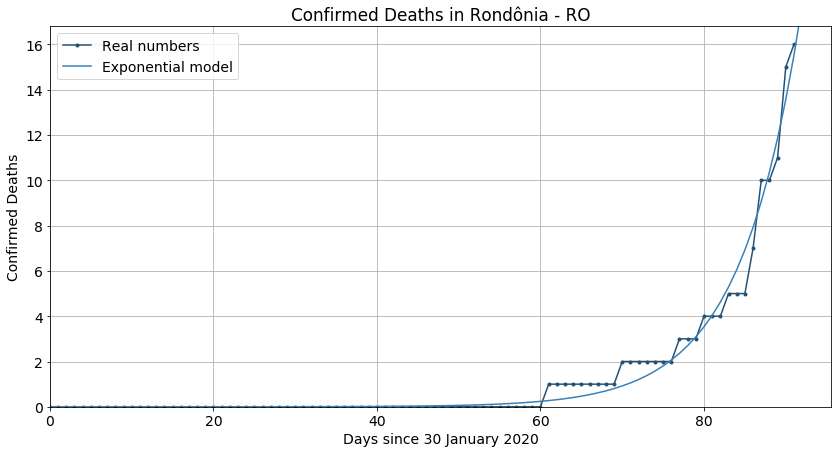

Next estimated number of confirmed cases is 17.752 or +1.752


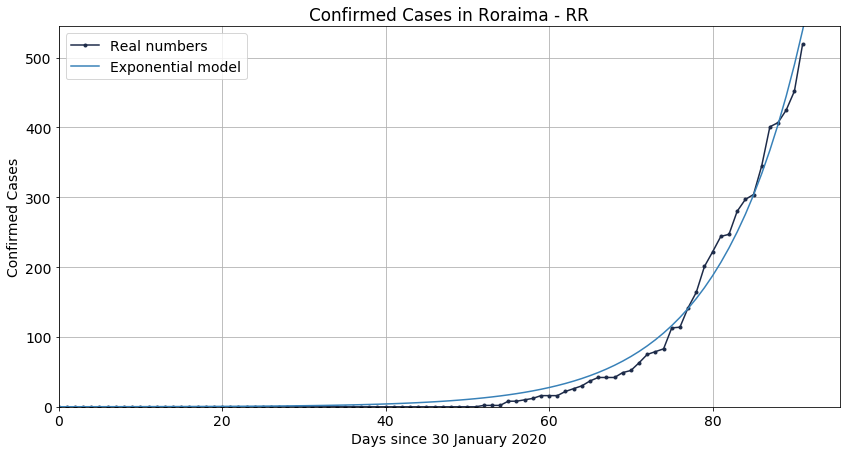

Next estimated number of confirmed cases is 593.288 or +74.288


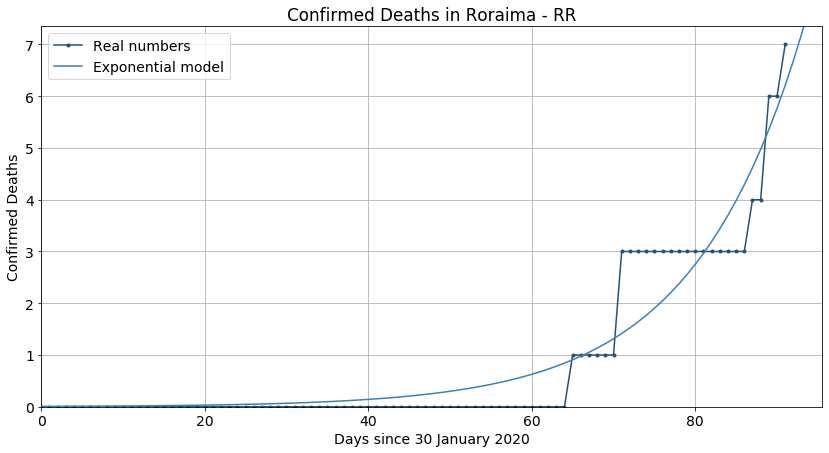

Next estimated number of confirmed cases is 6.685 or +-0.315


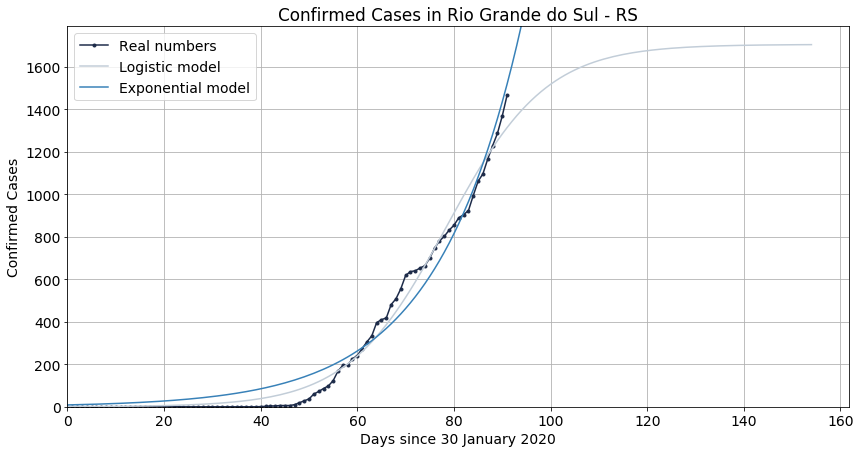

Next estimated number of confirmed cases is 1606.484 or +140.484


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


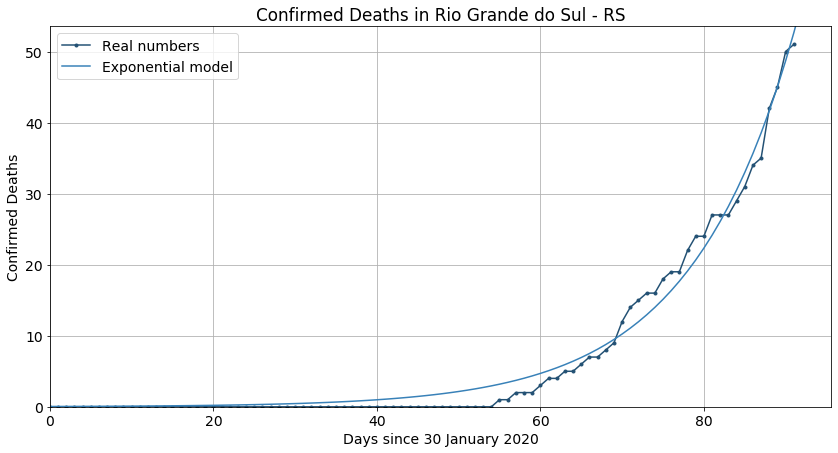

Next estimated number of confirmed cases is 56.911 or +5.911


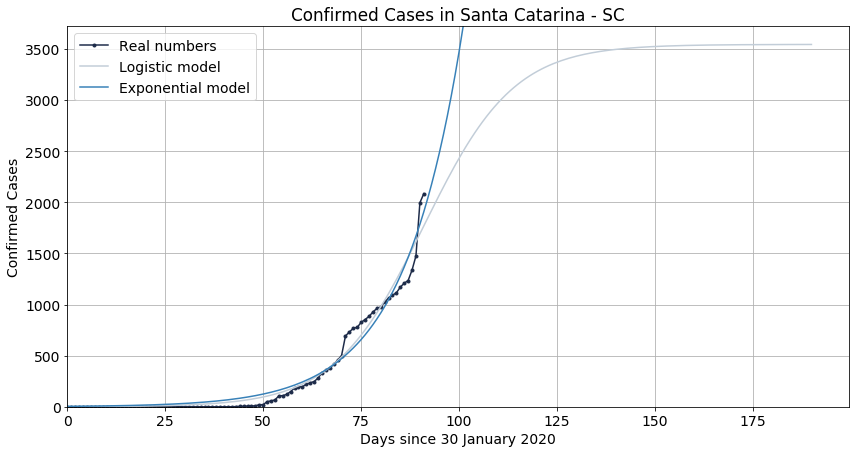

Next estimated number of confirmed cases is 2038.004 or +-46.996


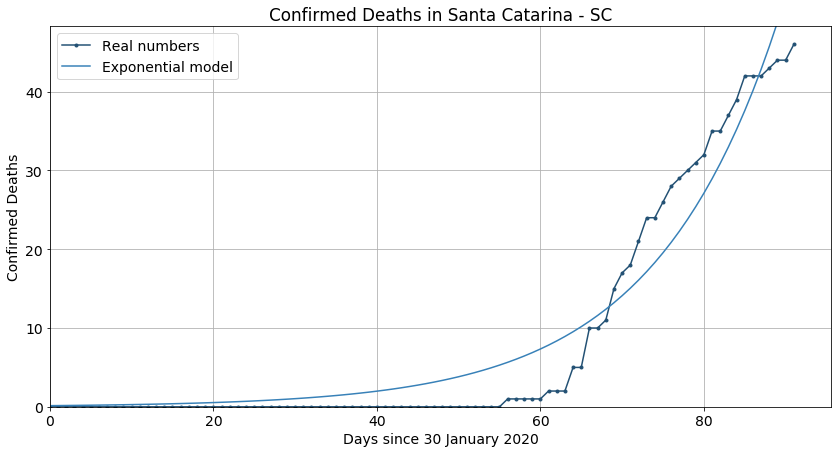

Next estimated number of confirmed cases is 59.403 or +13.403


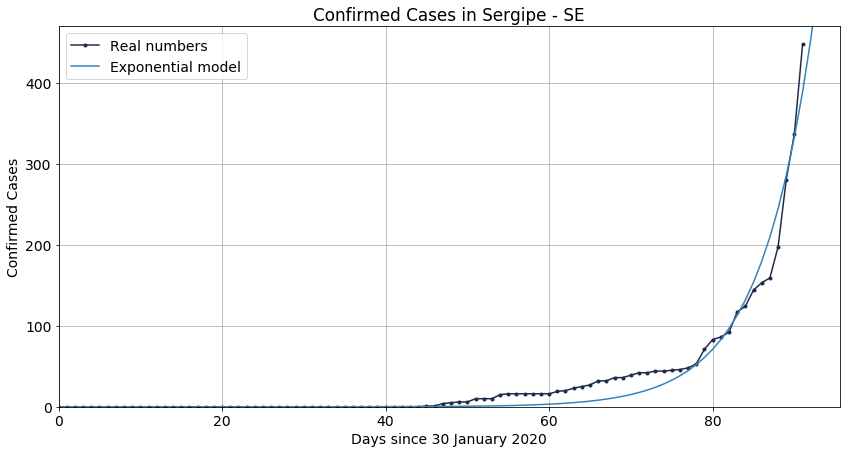

Next estimated number of confirmed cases is 453.196 or +6.196


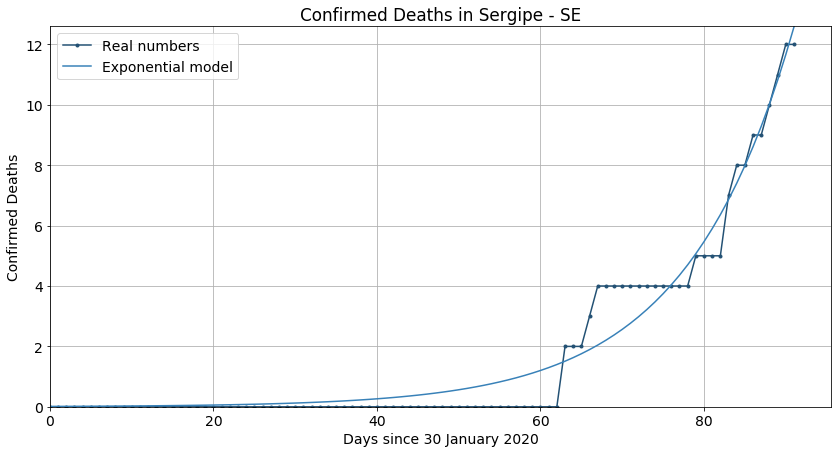

Next estimated number of confirmed cases is 13.565 or +1.565


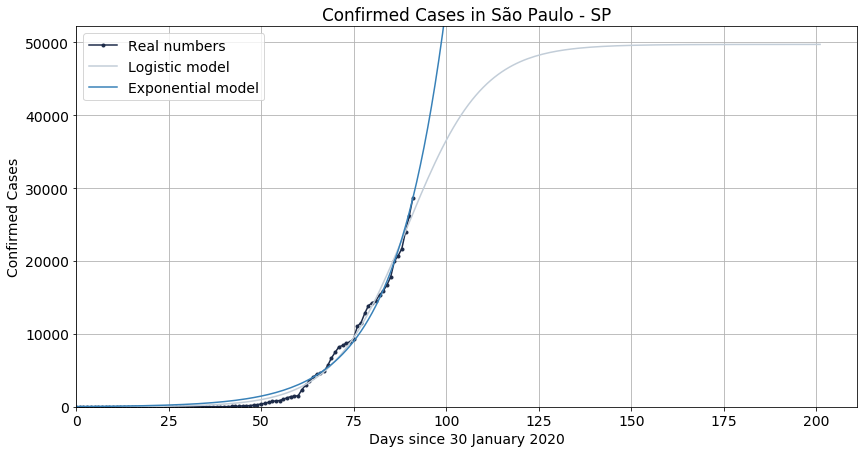

Next estimated number of confirmed cases is 30813.583 or +2115.583


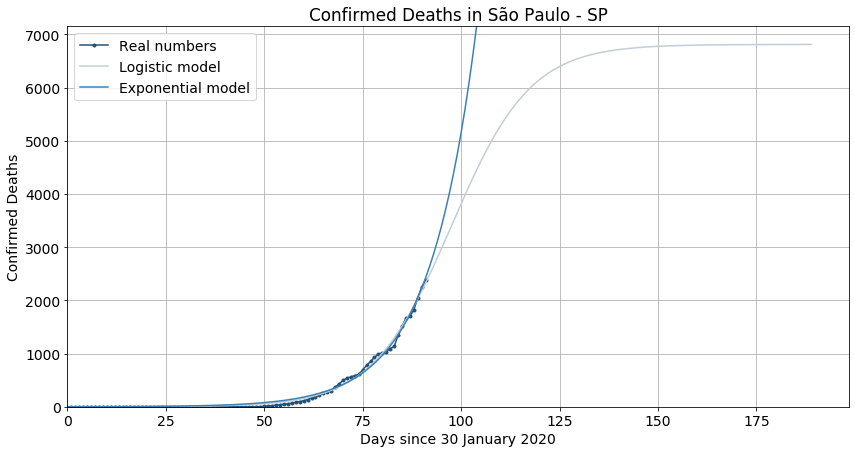

Next estimated number of confirmed cases is 2639.596 or +264.596


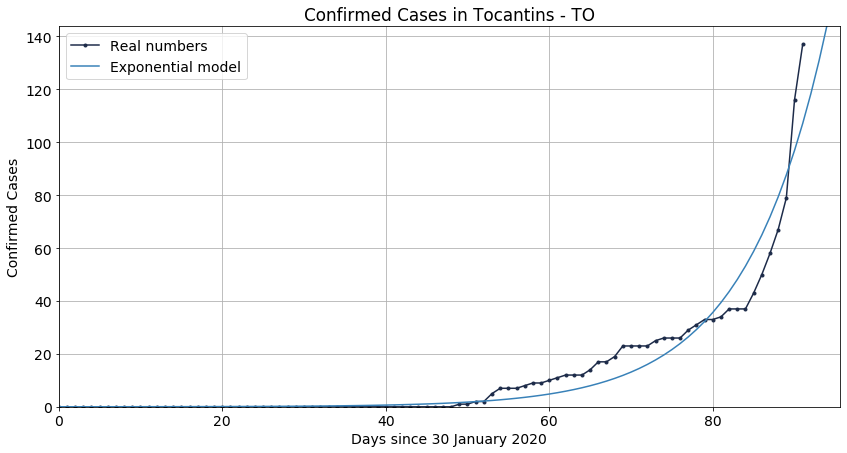

Next estimated number of confirmed cases is 118.367 or +-18.633


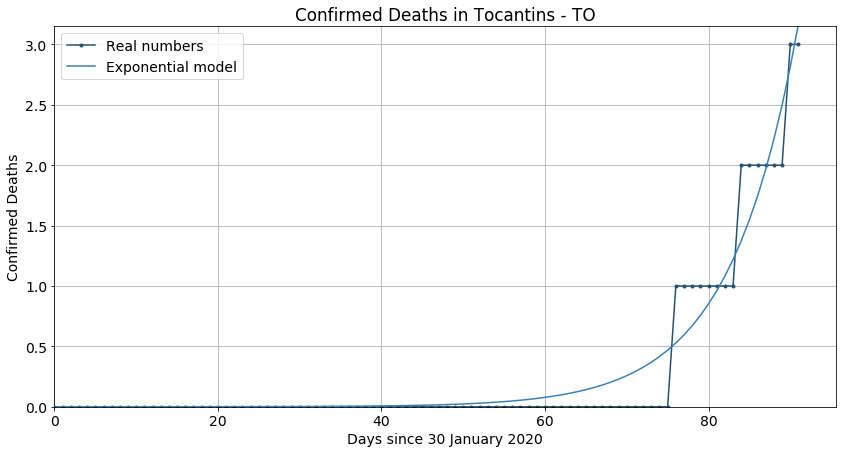

Next estimated number of confirmed cases is 3.574 or +0.574


In [10]:
plt.rc('font', size = 14)
plt.rcParams['figure.figsize'] = [14, 7]

ttl = ["Confirmed Cases", "Confirmed Deaths"]
dfs = dfs.sort_values('estado')
estados = dfs["estado"].unique()
cor = ["#1d2b49", "#235174"]

for e in estados :
    df_e = df_UF.loc[df_UF.iloc[:, 0] == e, :].iloc[:, [2, 4, 1]].sort_values("data")
    pop = brasil.at[brasil['UF'].eq(e).idxmax(),'População']
    est = brasil.at[brasil['UF'].eq(e).idxmax(),'Unidade da Federação']
   
    for f in range(2) :
        plt.grid(True)
        x = days
        
        # Real Numbers
        y = list(df_e.iloc[:, f])
        plt.plot(x, y, marker = '.', label = "Real numbers", color = cor[f])        

        # Lines    

        if max(y) > 1000 :
            logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[f * 2], 0.1 * pop])
            logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                                logistic_fit[0][2]) - int(logistic_fit[0][2]),
                                      logistic_fit[0][1]))

            pred_x = list(range(max(x), logistic_sol))

            # Predicted logistic curve
            plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                                  for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")
            
            plt.xlim(0, max(pred_x) * 1.05)
            plt.ylim(0, logistic_fit[0][2] * 1.05)
        else :
            
            pred_x = list(range(max(x), max(x) + 15))
            
            plt.xlim(0, max(x) * 1.05)
            plt.ylim(0, max(y) * 1.05)
        
        exp_p = exp_param([y[-5], y[-3], y[-1]], [x[-5], x[-3], x[-1]])
        exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] * np.exp(-1), exp_p[1], 1])        

        plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                              for i in x + pred_x], label = "Exponential model", color = "#3881b8")

        plt.title(ttl[f] + " in " + est + " - " + e)
        plt.legend()
        plt.xlabel("Days since 30 January 2020")
        plt.ylabel(ttl[f])
        plt.show()
        print("Next estimated number of confirmed cases is " + 
              str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]), 3))
              + " or +" + 
              str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) - max(y), 3))  )